In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/audi.csv")

# separate out target variable
y = df['price']
X = df.loc[:, df.columns != 'price']


In [68]:
# Compute a baseline
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_percentage_error

avg_price = np.mean(y)
print(avg_price)
y_pred = [avg_price] * len(y)
baseline_MAPE_mean = mean_absolute_percentage_error(y_pred, y)

med_price = np.median(y)
print(med_price)

y_pred = [med_price] * len(y)
baseline_MAPE_median = mean_absolute_percentage_error(y_pred, y)

print('Our baseline MAPE using the average price is ' + str(baseline_MAPE_mean))
print('Our baseline MAPE using the median price is ' + str(baseline_MAPE_median))

        

22896.685039370077
20200.0
Our baseline MAPE using the average price is 0.36633076533017894
Our baseline MAPE using the median price is 0.4019132169122424


In [ ]:
# Feature Engineering 
X['log_mileage'] = np.log(X['mileage'])
X['log_mpg'] = np.log(X['mpg'])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split 

#Create train set
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.9, random_state= 42)

# Split test, val
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, train_size=0.5, random_state= 42)

# categorical features
onehot_ftrs = ['model','fuelType','transmission']

# continuous with well-defined min/max
minmax_ftrs = ['year', 'engineSize']

# continuous better suited for StandardScaler
std_ftrs = ['tax', 'mileage', 'mpg', 'log_mileage', 'log_mpg']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('onehot' , OneHotEncoder(sparse=False, handle_unknown = 'ignore'), onehot_ftrs)
    ], remainder = 'passthrough', verbose_feature_names_out = False)

# special encoder for the Lasso, EN models that drops a category during OneHot encodign
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('onehot' , OneHotEncoder(sparse=False, handle_unknown = 'ignore', drop = 'first'), onehot_ftrs)
    ], remainder = 'passthrough', verbose_feature_names_out = False)

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


def MLpipe_KFold_MAPE(feature_matrix, target_var, preprocessor, init_ml, param_grid, random_states):
    
    models = []
    for random_state in random_states:
        np.random.seed(random_state)

        # create a test set
        X_other, X_test, y_other, y_test = train_test_split(feature_matrix, target_var, test_size=0.05, random_state= random_state)
        
        # preprocess
        kf = KFold(n_splits=4,shuffle=True, random_state= random_state)
                
        # Make pipeline
        final_scaler = StandardScaler()
        
        # Add another standard scaler after the one hots to make the linear models more interpretable
        pl = Pipeline(steps=[('preprocessor', preprocessor), ('final_scaler', final_scaler), ('model', init_ml)])
        
        # Make GridSearch
        grid = GridSearchCV(pl, param_grid=param_grid, scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False), cv=kf, n_jobs = -1)

        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        
        test_score = mean_absolute_percentage_error(y_test, y_pred)
        
        # record best model
        models.append((grid, grid.best_score_, test_score , X_test, y_test, random_state))
        
    
    return pd.DataFrame.from_records(models,columns = ['Grid', 'Val Score', 'Test Score', 'Test Set', 'Y Test', 'Random State'])

In [183]:
import pickle
from sklearn.linear_model import Lasso
import numpy as np

# Only tune one hyperparameter for the Lasso
param_grid = {
              'model__alpha': (np.logspace(-6,0,21))
              } 

l1 = Lasso(max_iter = 10000000)
# Looping over 3 random states
best_models= MLpipe_KFold_MAPE(X, y, preprocessor_lasso, l1, param_grid, random_states= [1,2,3,4,5])
file = open('../results/pickles/lasso.save', 'wb')
pickle.dump(best_models,file)
file.close()

print('Our average test score is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))

/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all

Our average test score is 0.1347178612293481, with a standatrd deviation of 0.015358736018135975


In [ ]:

import pickle
from sklearn.linear_model import Ridge

# Again only looping over one hyperparameter
param_grid = {
              'model__alpha': (np.logspace(-8,0,21))
              } 

l2 = Ridge(max_iter = 100000000)

best_models= MLpipe_KFold_MAPE(X, y, preprocessor, l2, param_grid, random_states= [1,2,3,4,5])
file = open('../results/pickles/ridge.save', 'wb')
pickle.dump(best_models,file)
file.close()

print('Our average test score is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))

In [ ]:

import pickle
from sklearn.linear_model import ElasticNet

# Again only looping over one hyperparameter
param_grid = {
              'model__alpha': (np.logspace(-2,0,21)),
              'model__l1_ratio': (np.logspace(-3,0,21, endpoint = False))
              } 

en = ElasticNet(max_iter = 100000000)

best_models= MLpipe_KFold_MAPE(X, y, preprocessor_lasso, en, param_grid, random_states= [1,2,3,4,5])
file = open('../results/pickles/en.save', 'wb')
pickle.dump(best_models,file)
file.close()

print('Our average test score is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))

In [206]:
import xgboost
from sklearn.model_selection import ParameterGrid

random_states = [1,2,3,4,5]
best_models = []

# Manually loop over random states, hyper params to enable early stopping
for i in random_states:
    
    X_train, X_other, y_train, y_other = train_test_split(X,y,\
                    train_size = 0.9,random_state = i, shuffle = True)

    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
                        train_size = 0.5,random_state = i, shuffle = True)
    
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)

    param_grid = {#"learning_rate": [0.03],
                "n_estimators": [100],
                #"seed": [0],
                #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                "missing": [np.nan], 
                #"max_depth": [1,3,10,30,100],
                # "max_depth" : [1],
                "colsample_bytree": [0.9],  
                "random_state" : [i],            
                "subsample": [0.66]}
    
    
    learning_rates = np.linspace(0,1, 10)
    depths = [1,3,8,10,15]
    models = []
    val_score = []
    
    # Tuning on learning rate
    for lr in learning_rates:
        for d in depths:
            XGB = xgboost.XGBRegressor()
            XGB.set_params(learning_rate = lr, max_depth = d, **ParameterGrid(param_grid)[0])
            XGB.fit(X_train_prep,y_train, early_stopping_rounds = 50, eval_set=[(X_val_prep, y_val)], verbose=False)
            y_pred = XGB.predict(X_val_prep)
            CV_mape = mean_absolute_percentage_error(y_pred, y_val)
            val_score.append(CV_mape)
            models.append(XGB)
    
    t_test_mape = mean_absolute_percentage_error(models[np.argmin(val_score)].predict(X_test_prep), y_test)
    X_test_prep = pd.DataFrame(X_test_prep, columns= preprocessor.get_feature_names_out())

    best_models.append((XGB, t_test_mape, X_test_prep, y_test.values))

best_models = pd.DataFrame.from_records(best_models,columns = ['Model', 'Test Score', 'Test Set', 'Y Test'])
print('Our average test score with XGB is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))

file = open('../results/pickles/xgb_early_stopping.save', 'wb')
pickle.dump(best_models,file)
file.close()

Our average test score with XGB is 0.06758417730685377, with a standatrd deviation of 0.0020225123736187403


In [184]:
import pickle
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
param_grid = {
              'model__n_neighbors': [1,3,10,15,20,30],
              'model__weights' : ['uniform', 'distance']
              } 

best_models = MLpipe_KFold_MAPE(X, y, preprocessor, knn, param_grid, random_states= [1,2,3,4,5])

file = open('../results/pickles/knn.save', 'wb')
pickle.dump(best_models,file)
file.close()
print('Our average test score with KNeighborsRegressor is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))


Our average test score with KNeighborsRegressor is 0.0794113554342534, with a standatrd deviation of 0.002058598093658747


In [185]:
import pickle
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
param_grid = {
              'model__n_estimators': [1, 3, 10, 30],
              'model__max_depth':[1, 3, 7, 10, 30]
              } 

best_models = MLpipe_KFold_MAPE(X, y, preprocessor, rf, param_grid, random_states= [1,2,3,4,5])

file = open('../results/pickles/rf.save', 'wb')
pickle.dump(best_models,file)
file.close()
print('Our average test score with RandomForestRegressor is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))


Our average test score with RandomForestRegressor is 0.07308583928581316, with a standatrd deviation of 0.002594115321983456


In [283]:
import pickle
from sklearn.svm import SVR

sv = SVR()
param_grid = {
              'model__C': (1/ (np.logspace(-7,0,11))),
              'model__gamma':  [1e-3, 1e-1, 1e1, 1e3, 1e5]
              } 

best_models = MLpipe_KFold_MAPE(X, y, preprocessor, sv, param_grid, random_states = [1,2,3])

file = open('../results/pickles/svr.save', 'wb')
pickle.dump(best_models,file)
file.close()
print('Our average test score with a SVM is ' + str(np.mean(best_models['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(best_models['Test Score'])))


Our average test score with a SVM is 0.07532654109706456, with a standatrd deviation of 0.0012759896881877246


### Model summary

In [54]:
# Collect results
lasso = pd.read_pickle('../results/pickles/lasso.save')
ridge = pd.read_pickle('../results/pickles/ridge.save')
en = pd.read_pickle('../results/pickles/en.save')

rf =  pd.read_pickle('../results/pickles/rf.save')
knn =  pd.read_pickle('../results/pickles/knn.save')
xgb =  pd.read_pickle('../results/pickles/xgb_early_stopping.save')
svr =  pd.read_pickle('../results/pickles/svr.save')



In [55]:
# Print avereage test scores
print('Our average test score with Lasso is ' + str(np.mean(lasso['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(lasso['Test Score'])))
print('Our average test score with Ridge is ' + str(np.mean(ridge['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(ridge['Test Score'])))
print('Our average test score with EN is ' + str(np.mean(en['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(en['Test Score'])))

print('Our average test score with KNN is ' + str(np.mean(knn['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(knn['Test Score'])))
print('Our average test score with RF is ' + str(np.mean(rf['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(rf['Test Score'])))
print('Our average test score with XGB is ' + str(np.mean(xgb['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(xgb['Test Score'])))
print('Our average test score with SVR is ' + str(np.mean(svr['Test Score'])) +', with a standatrd deviation of ' +  str(np.std(svr['Test Score'])))

Our average test score with Lasso is 0.1347178612293481, with a standatrd deviation of 0.015358736018135975
Our average test score with Ridge is 0.13420141908125682, with a standatrd deviation of 0.015118739687565889
Our average test score with EN is 0.12743039314247978, with a standatrd deviation of 0.010505635689681407
Our average test score with KNN is 0.0794113554342534, with a standatrd deviation of 0.002058598093658747
Our average test score with RF is 0.07308583928581316, with a standatrd deviation of 0.002594115321983456
Our average test score with XGB is 0.06758417730685377, with a standatrd deviation of 0.0020225123736187403
Our average test score with SVR is 0.07532654109706456, with a standatrd deviation of 0.0012759896881877246


In [60]:
means = [np.mean(lasso['Test Score']), np.mean(ridge['Test Score']), np.mean(en['Test Score']), np.mean(svr['Test Score']), 
         np.mean(knn['Test Score']), np.mean(rf['Test Score']), np.mean(xgb['Test Score'])]

std = [np.std(lasso['Test Score']), np.std(ridge['Test Score']), np.std(en['Test Score']), np.std(svr['Test Score']),
       np.std(knn['Test Score']), np.std(rf['Test Score']), np.std(xgb['Test Score'])]

models = ['Lasso', 'Ridge', 'EN', 'SVR','KNN', 'RandomForest', 'XGB']

p = pd.DataFrame(list(zip(means, std, models)), columns = ['Mean Test Score', 'Std Test Score', 'Model'])

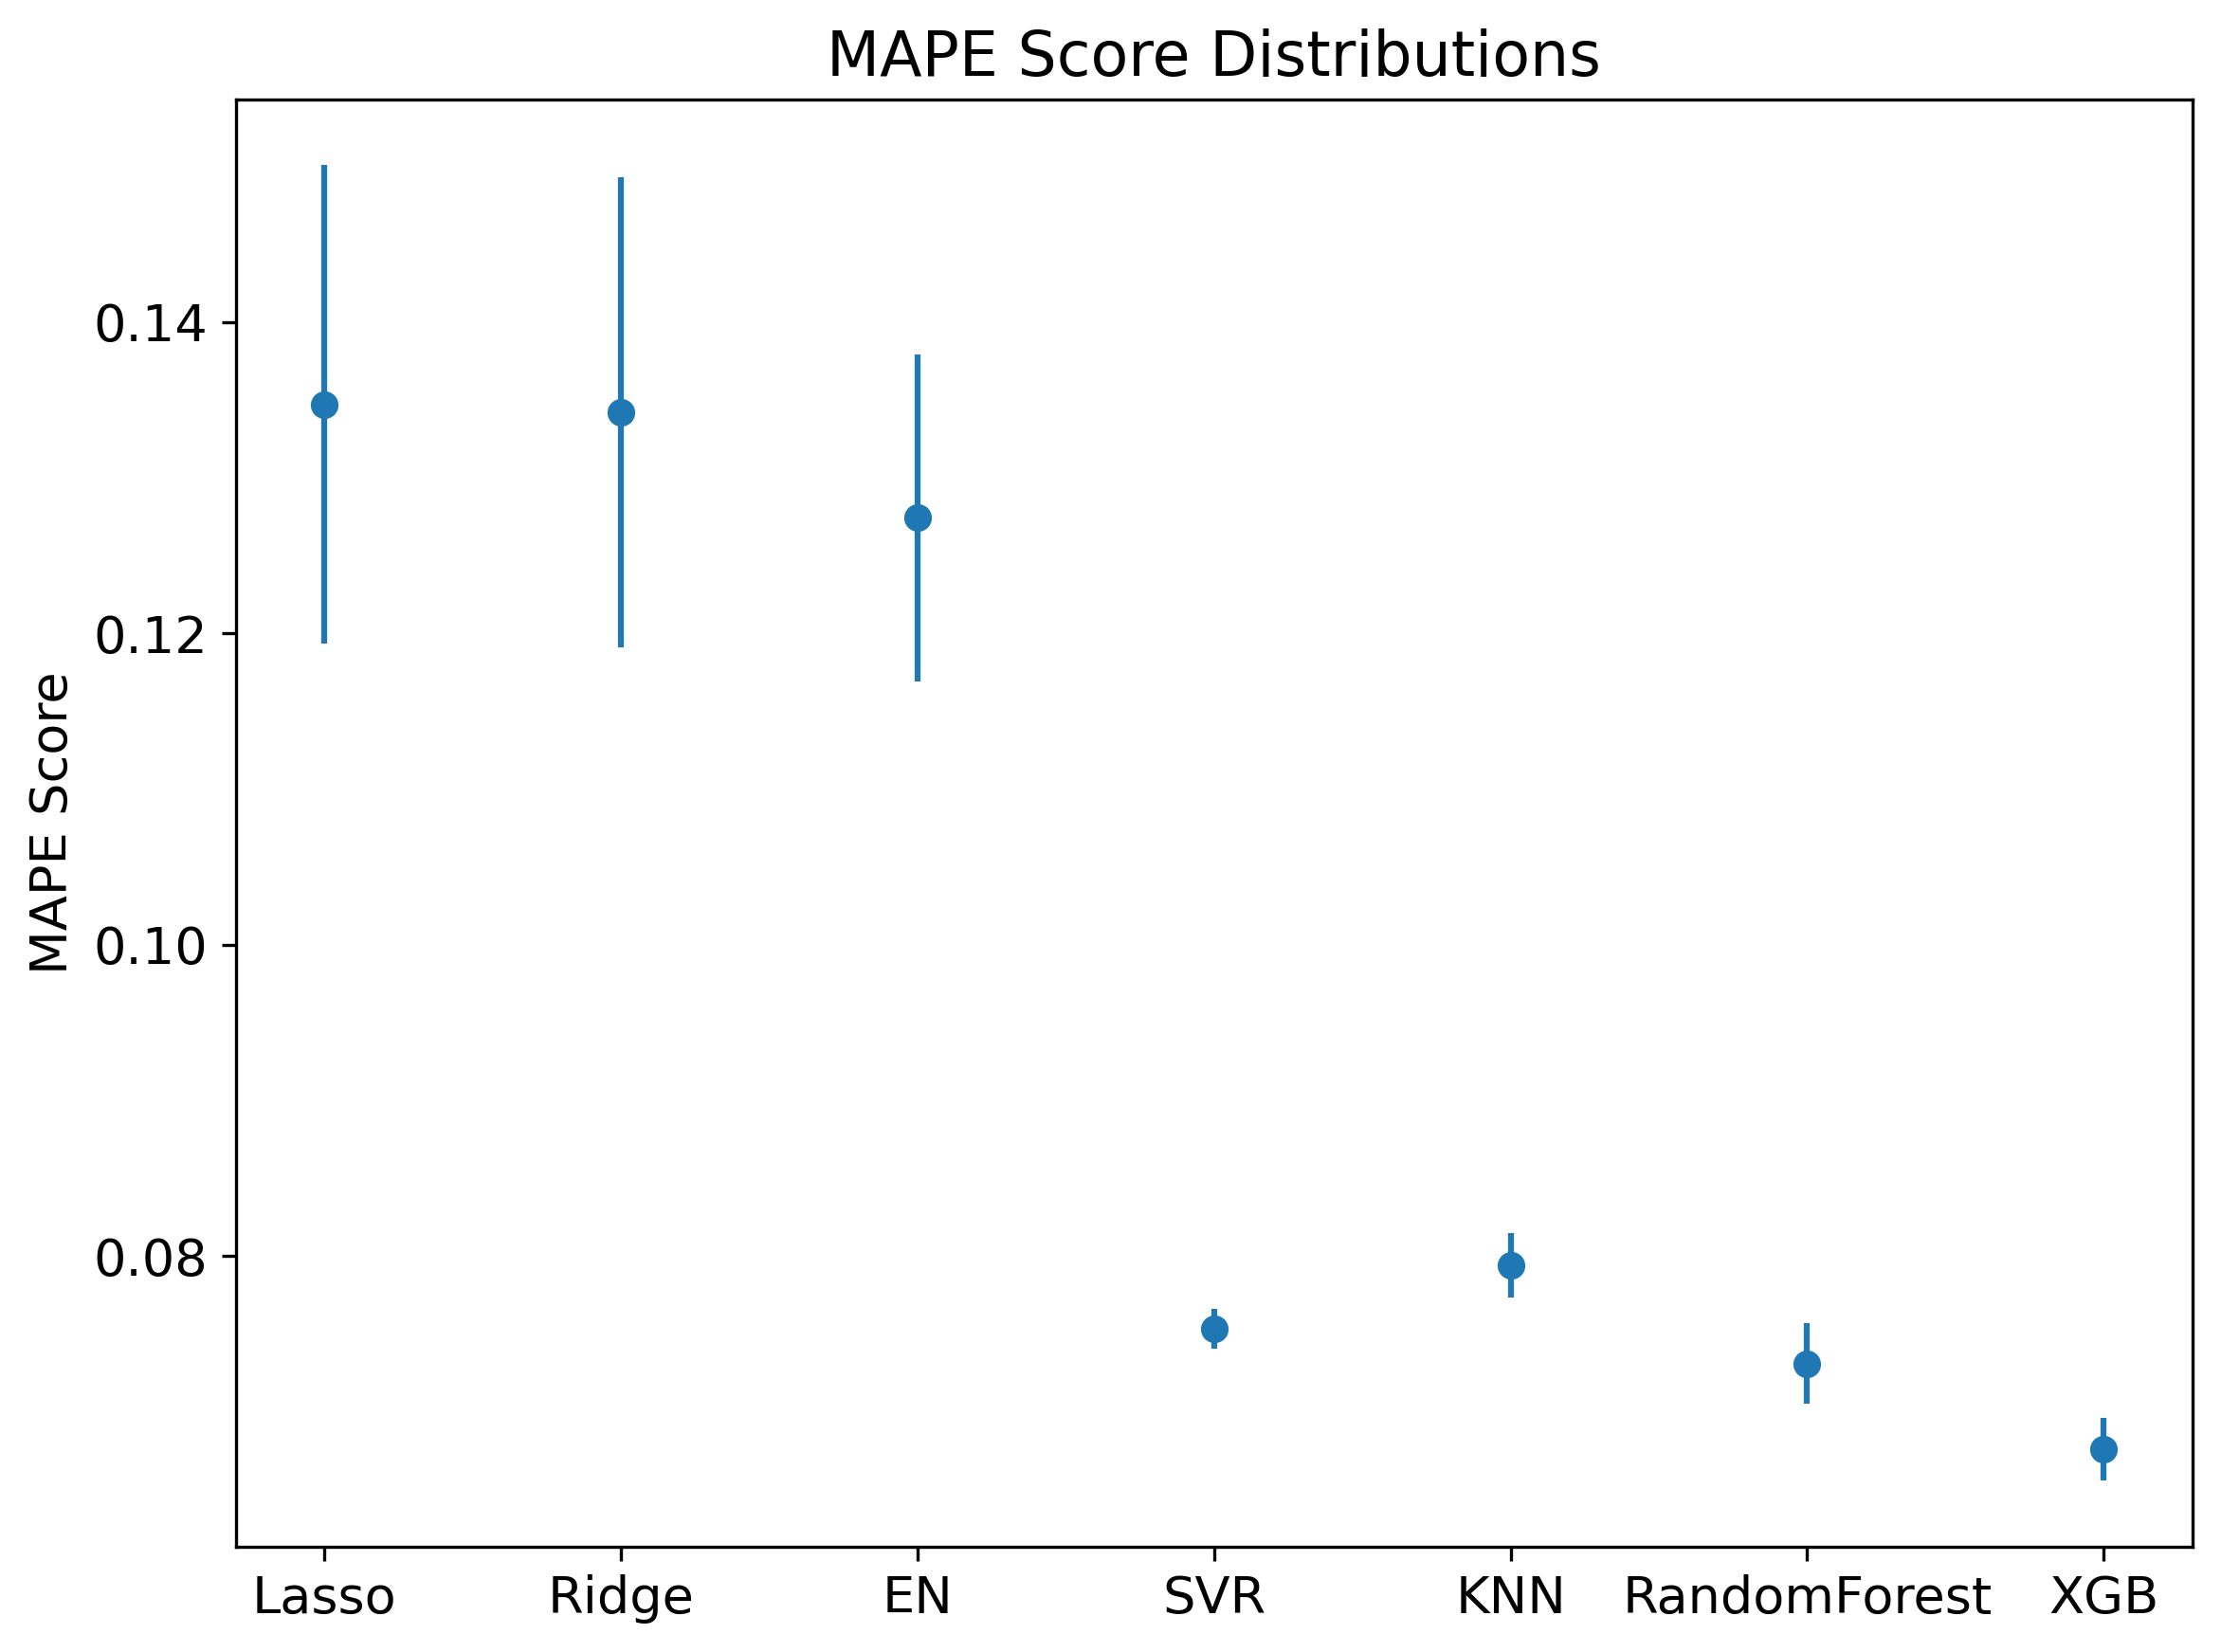

In [67]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=300)
plt.scatter(y= p['Mean Test Score'], x = p['Model'])
plt.errorbar(y= p['Mean Test Score'], x = p['Model'], yerr= p['Std Test Score'], ls = 'none')
plt.ylabel('MAPE Score')
plt.title('MAPE Score Distributions')
plt.tight_layout() 
plt.savefig('../figures/MAPEs.png')
plt.show()

### Feature Importance

In [ ]:
# Feature permutation 
import matplotlib.pylab as plt
best_models = pd.read_pickle('../results/pickles/rf.save')

# best model
bm = np.argmin(best_models['Test Score'])

nr_runs = 10

# Test set from best model
X_test = best_models.iloc[bm]['Test Set']

# Y test from best model
y_test = best_models.iloc[bm]['Y Test']

#X_test = X_test.values

X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[0].transform(X_test)
X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[1].transform(X_test_transformed)
feature_names = best_models.iloc[bm]['Grid'].best_estimator_[0].get_feature_names_out()
scores = np.zeros([len(feature_names),nr_runs])

X_test_transformed = pd.DataFrame(X_test_transformed, columns = feature_names)
#X_test_transformed = pd.DataFrame(X_test_transformed, columns = feature_names)
model = best_models['Grid'][bm].best_estimator_[2]

test_score = (model.score(X_test_transformed, y_test))

for i in range(len(feature_names)):
    # print('shuffling '+str(feature_names[i]))
    mape_scores = []
    
    # Generate a score with shuffled i, nr_runs times
    for j in range(nr_runs):
        X_test_shuffled = X_test_transformed.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_transformed[feature_names[i]])
        mape_scores.append(model.score(X_test_shuffled.values,y_test))
    # print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = mape_scores
    

# Sort by the average test score
sorted_indcs = np.argsort(np.mean(scores,axis=1))

# Take the 10 features with the LOWEST test score, ie. greatest deviation from the true test score
sorted_indcs = sorted_indcs[0:10]

# Order the top 10 with the smallest test score first
sorted_indcs = sorted_indcs[::-1]


plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(scores[sorted_indcs].T,labels=feature_names[sorted_indcs],vert=False)
#plt.boxplot(scores[sorted_indcs].T,vert=False)

plt.axvline(test_score,label='test score')
plt.title("Top 10 Permutation Importances")
plt.xlabel('R2 Score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import shap

best_models = pd.read_pickle('../results/pickles/en.save')

# best model
bm = np.argmin(best_models['Test Score'])

# Test set from best model
X_test = best_models.iloc[bm]['Test Set']

# transform the test set
X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[0].transform(X_test)
X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[1].transform(X_test_transformed)



explainer = shap.explainers.Linear(best_models.iloc[1]['Grid'].best_estimator_[2], X_test_transformed[:1000])


# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
feature_names = best_models.iloc[bm]['Grid'].best_estimator_[0].get_feature_names_out()
shap.summary_plot(shap_values, X_test_transformed,feature_names = feature_names, max_display = 40, show = False)
plt.show()


In [ ]:
# Lasso coefs from best model

import matplotlib.pylab as plt
from matplotlib.pyplot import figure

best_models = pd.read_pickle('../results/pickles/en.save')

# best model
bm = np.argmin(best_models['Test Score'])

feature_names = best_models.iloc[bm]['Grid'].best_estimator_[0].get_feature_names_out()

plt.barh(feature_names, best_models.iloc[bm]['Grid'].best_estimator_[2].coef_)
plt.show()


In [ ]:
import shap
shap.initjs() # required for visualizations later on
shap.force_plot(explainer.expected_value, shap_values[100], features = X_test_transformed[100], figsize = (30,3), feature_names = feature_names, matplotlib = True, show = False)
plt.show()

In [ ]:
import shap
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
shap.initjs() # required for visualizations later on

best_models = pd.read_pickle('../results/pickles/rf.save')

# best model
bm = np.argmin(best_models['Test Score'])

# Test set from best model
X_test = best_models.iloc[bm]['Test Set']

# transform the test set
X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[0].transform(X_test)
X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[1].transform(X_test_transformed)


explainer = shap.TreeExplainer(best_models.iloc[bm]['Grid'].best_estimator_[2], X_test_transformed)


# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)
feature_names = best_models.iloc[bm]['Grid'].best_estimator_[0].get_feature_names_out()
shap.summary_plot(shap_values, X_test_transformed,feature_names = feature_names, max_display = 40)
plt.show()


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


<Figure size 2400x1800 with 0 Axes>

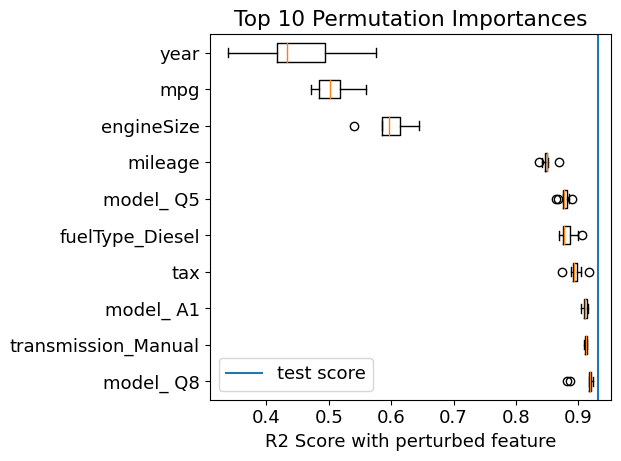

In [73]:
# XGB Permutation
# Feature permutation 
import matplotlib.pylab as plt
best_models = pd.read_pickle('../results/pickles/xgb_early_stopping.save')

# best model
bm = np.argmin(best_models['Test Score'])

nr_runs = 10

# Test set from best model- already transformed
X_test_transformed = best_models.iloc[bm]['Test Set']

# Y test from best model
y_test = best_models.iloc[bm]['Y Test']

#X_test = X_test.values

#X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[0].transform(X_test)
#X_test_transformed = best_models.iloc[bm]['Grid'].best_estimator_[1].transform(X_test_transformed)
feature_names = X_test_transformed.columns
scores = np.zeros([len(feature_names),nr_runs])

X_test_transformed = pd.DataFrame(X_test_transformed, columns = feature_names)
#X_test_transformed = pd.DataFrame(X_test_transformed, columns = feature_names)
model = best_models['Model'][bm]

test_score = (model.score(X_test_transformed, y_test))

for i in range(len(feature_names)):
    # print('shuffling '+str(feature_names[i]))
    mape_scores = []
    
    # Generate a score with shuffled i, nr_runs times
    for j in range(nr_runs):
        X_test_shuffled = X_test_transformed.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_transformed[feature_names[i]])
        mape_scores.append(model.score(X_test_shuffled.values,y_test))
    # print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = mape_scores
    

# Sort by the average test score
sorted_indcs = np.argsort(np.mean(scores,axis=1))

# Take the 10 features with the LOWEST test score, ie. greatest deviation from the true test score
sorted_indcs = sorted_indcs[0:10]

# Order the top 10 with the smallest test score first
sorted_indcs = sorted_indcs[::-1]

figure(figsize=(8, 6), dpi=300)
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(scores[sorted_indcs].T,labels=feature_names[sorted_indcs],vert=False)
#plt.boxplot(scores[sorted_indcs].T,vert=False)

plt.axvline(test_score,label='test score')
plt.title("Top 10 Permutation Importances")
plt.xlabel('R2 Score with perturbed feature')
plt.legend()
plt.tight_layout() 
plt.savefig('../figures/feature_permutation.png', dpi=300)
plt.show()

In [70]:
print(test_score)

0.9311486528993127


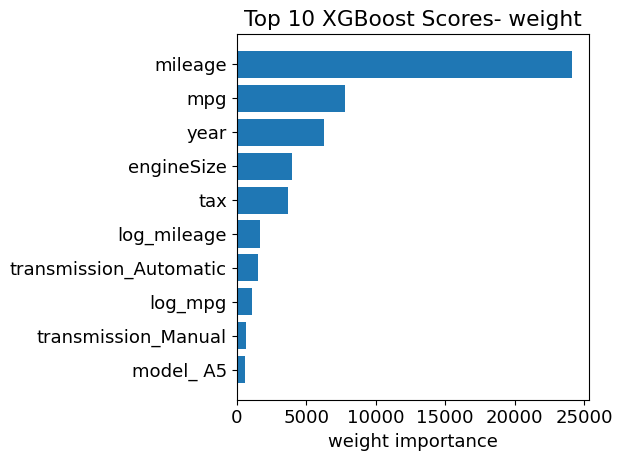

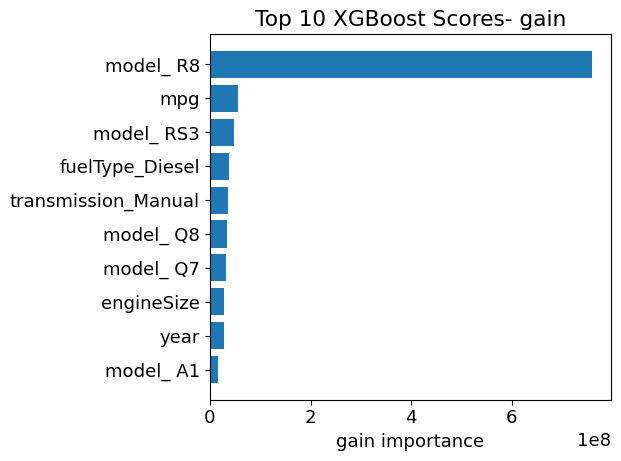

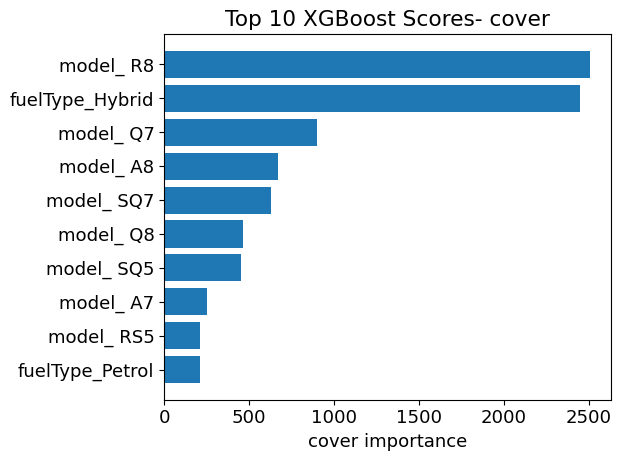

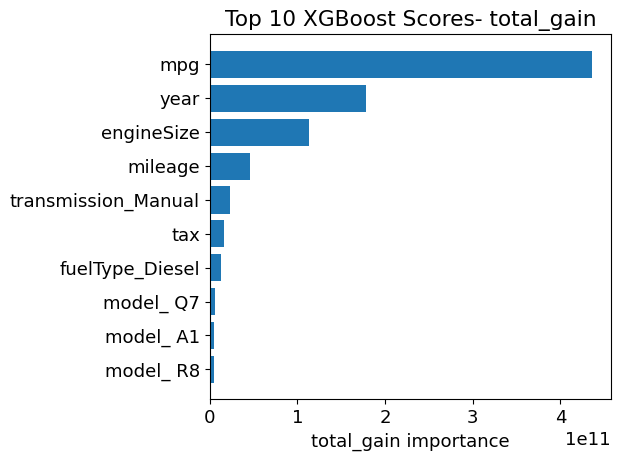

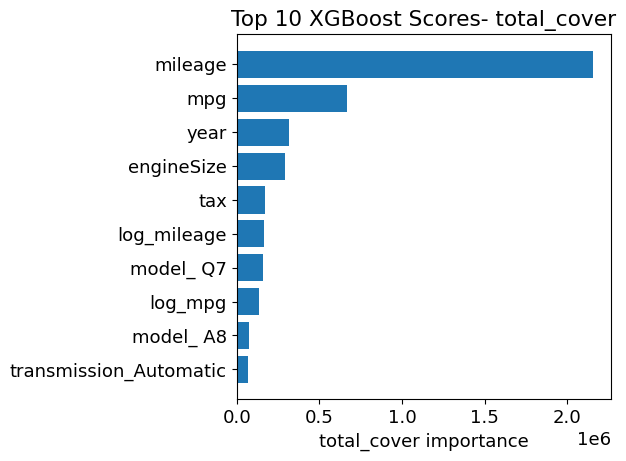

In [77]:
model.get_booster().feature_names = feature_names.tolist()

for scorer in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:

    s = model.get_booster().get_score(importance_type= scorer)
    s = pd.DataFrame.from_dict(s, orient = 'index')
    s = s.sort_values(by = 0, key = abs, ascending = False).iloc[:10]

    features = s.T.columns

    #plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(6.4,4.8))
    plt.barh(np.arange(10),s[0].sort_values())
    plt.yticks(np.arange(10),s.sort_values(by = 0).index)
    plt.title("Top 10 XGBoost Scores- " + scorer)
    plt.xlabel(scorer + ' importance')
    plt.tight_layout() 
    plt.savefig('../figures/XGB_fi_'+ scorer +'.png', dpi=300)
    plt.show()

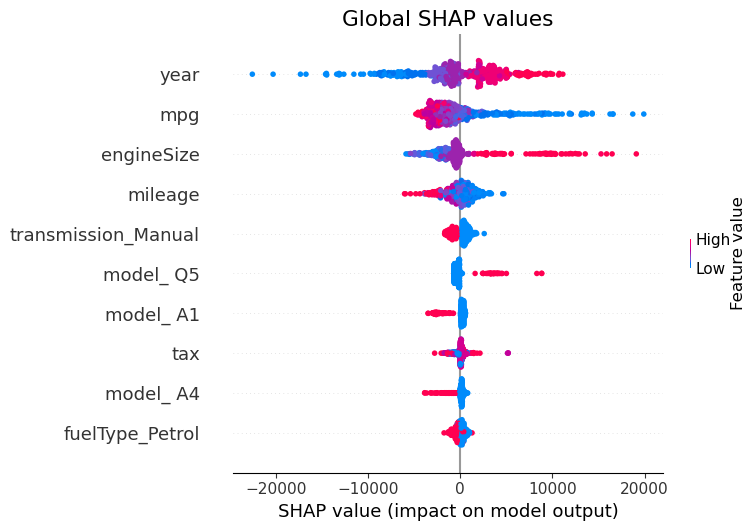

In [14]:
import shap
import matplotlib.pyplot as pl

explainer = shap.TreeExplainer(model, X_test_transformed)


# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)
shap.summary_plot(shap_values, X_test_transformed,feature_names = feature_names, max_display = 10, show = False)
plt.title('Global SHAP values')
plt.tight_layout() 

pl.savefig('../figures/XGB_global_shap.png',dpi=700)

plt.show()


In [257]:
from sklearn.metrics import mean_absolute_error

model = best_models['Model'][0]

y_pred = model.predict(X_test_transformed)
mean_absolute_error(y_test, y_pred)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


1290.6284947770366

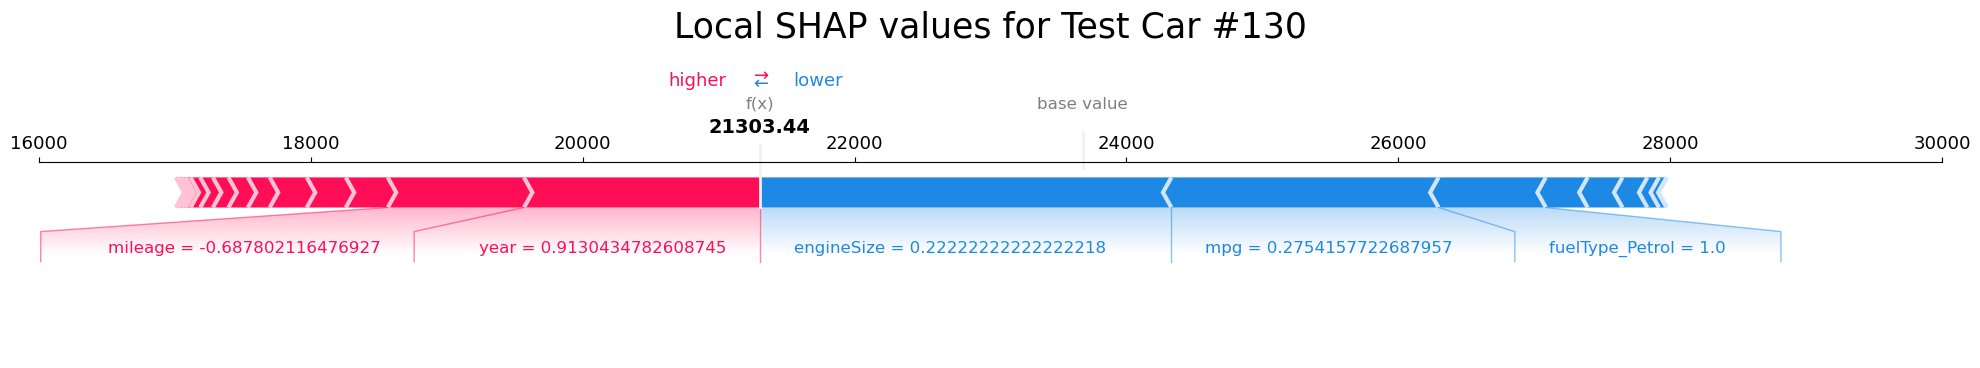

In [52]:
shap.force_plot(explainer.expected_value, shap_values[130],  figsize=(20, 4), features = X_test_transformed.values[130],
                feature_names = feature_names, matplotlib = True, show = False)
#pl.title('Local SHAP values for Test Car #130', y=1.75)
pl.tight_layout() 

pl.title('Local SHAP values for Test Car #130', y = 1.6, size = 25)
plt.xlim([16000, 30000])

pl.tight_layout() 

pl.savefig('../figures/Local_SHAP_130.png',dpi=600)

pl.show()

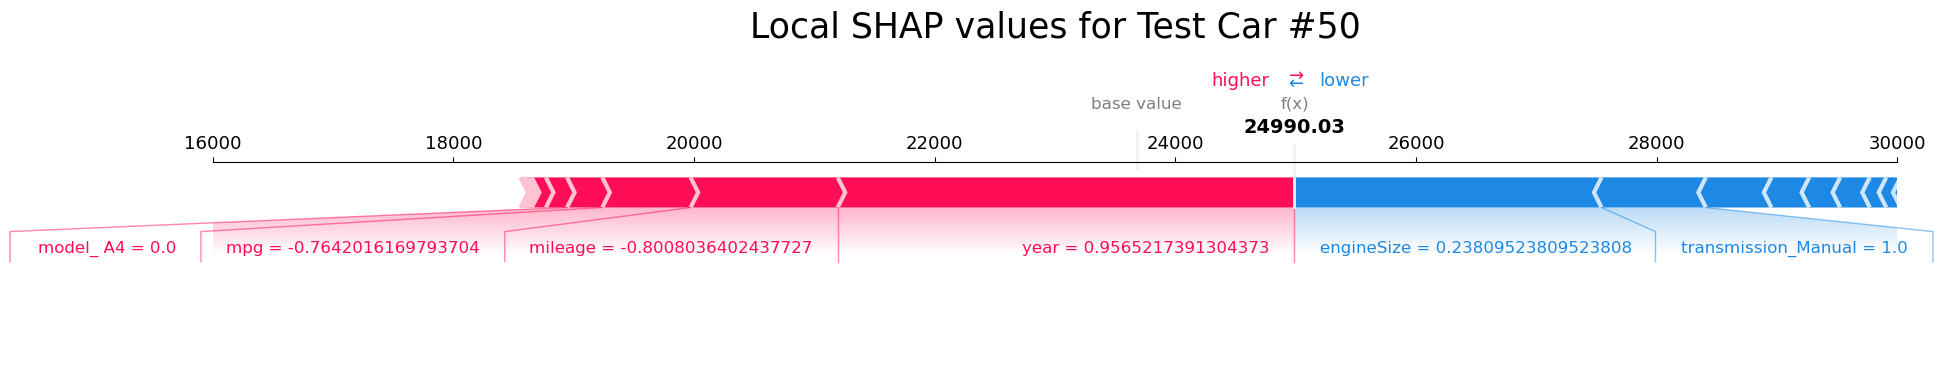

In [51]:
shap.force_plot(explainer.expected_value, shap_values[50],  figsize=(20, 4), features = X_test_transformed.values[50],feature_names = feature_names, matplotlib = True, show = False)
#pl.title('Local SHAP values for Test Car #130', y=1.75)
pl.tight_layout() 

pl.title('Local SHAP values for Test Car #50', y = 1.6, size = 25)
plt.xlim([16000, 30000])

pl.tight_layout() 
pl.savefig('../figures/Local_SHAP_50.png',dpi=600)

pl.show()